analysis borrowed from Sean Abu https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

ridership data originally obtained here http://ftp.uni-bayreuth.de/math/statlib/general/tsa2/cryer/cryer.htm

In [1]:
import numpy as np
import pylab
import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta

In [2]:
series = pd.read_csv('portland-oregon-average-monthly-70s.csv', index_col=0, parse_dates=[0], squeeze=True)
series = series.asfreq(pd.infer_freq(series.index))
series.to_csv('portland-oregon-average-monthly-70s.csv', index=True)

<AxesSubplot:xlabel='Date'>

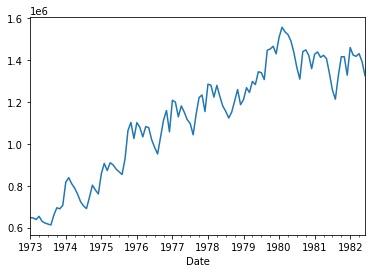

In [3]:
series.plot()

<AxesSubplot:xlabel='Date'>

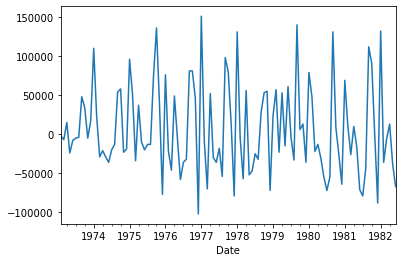

In [4]:
series.diff().dropna().plot()

<AxesSubplot:xlabel='Date'>

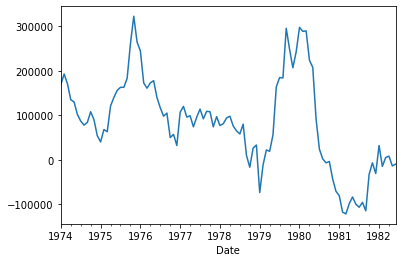

In [5]:
series.diff(12).dropna().plot()

<AxesSubplot:xlabel='Date'>

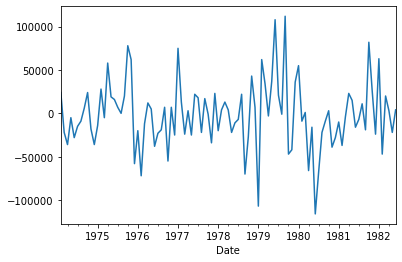

In [6]:
series.diff().diff(12).dropna().plot()

In [7]:
diffs = series.diff().diff(12).dropna()

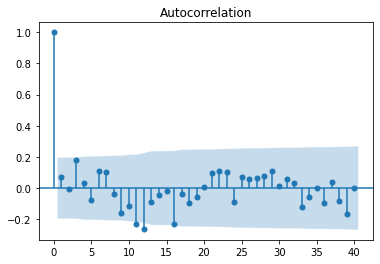

In [15]:
acf_plot = plot_acf(diffs, lags=40)

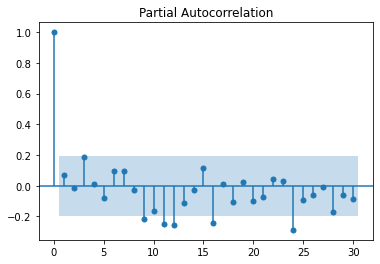

In [17]:
pacf_plot = plot_pacf(diffs, lags=30)

In [10]:
train_end = datetime(1982, 1, 30)

train_data = series[:train_end]
test_data = series[train_end :]
train_data

Date
1973-01-31     648000.0
1973-02-28     646000.0
1973-03-31     639000.0
1973-04-30     654000.0
1973-05-31     630000.0
                ...    
1981-08-31    1214000.0
1981-09-30    1326000.0
1981-10-31    1417000.0
1981-11-30    1417000.0
1981-12-31    1329000.0
Freq: M, Name: Riders, Length: 108, dtype: float64

In [11]:
test_data

Date
1982-01-31    1461000.0
1982-02-28    1425000.0
1982-03-31    1419000.0
1982-04-30    1432000.0
1982-05-31    1394000.0
1982-06-30    1327000.0
Freq: M, Name: Riders, dtype: float64

In [19]:
model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               Riders   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1132.688
Date:                              Mon, 22 Feb 2021   AIC                           2271.377
Time:                                      20:01:52   BIC                           2279.038
Sample:                                  01-31-1973   HQIC                          2274.473
                                       - 12-31-1981                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5561      0.132      4.206      0.000       0.297       0.815
ma.S.L12      -0.89

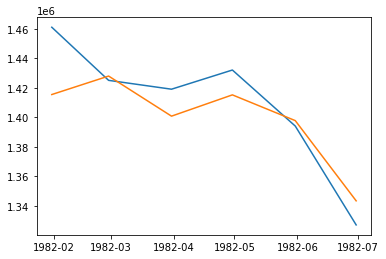

In [14]:
pylab.plot(test_data)
pylab.plot(model_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True))

In [159]:
series

1973-01-31     6480000
1973-02-28     6460000
1973-03-31     6390000
1973-04-30     6540000
1973-05-31     6300000
                ...   
1982-02-28    14250000
1982-03-31    14190000
1982-04-30    14320000
1982-05-31    13940000
1982-06-30    13270000
Freq: M, Name: 0, Length: 114, dtype: int64

In [20]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = series[:train_end-timedelta(days=1)]
    model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

Text(0, 0.5, 'Error')

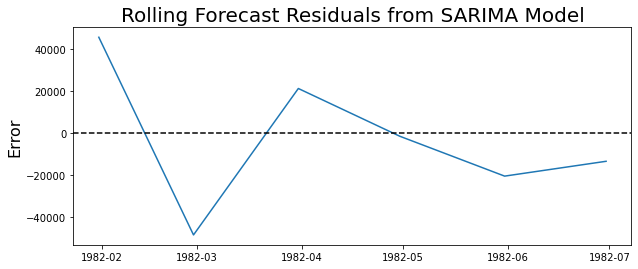

In [21]:
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)